In [58]:
import pandas as pd
import numpy as np
import scipy
from scipy.stats import ttest_1samp, ttest_ind
import glob
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib

DATADIR = '../data/' # directory that contains the anonymized data

cm = 1/2.54  # centimeters in inches
font = {'size': 7}
matplotlib.rc('font', **font)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [187]:
def assignRegion(row):
    
    # create a new region "NA and Oceania"
    
    if row.region == 'Americas':
        if row['sub-region'] == 'Northern America':
            return 'NA and Oceania'
        else:
            return row['sub-region']
        
    elif row.region == 'Oceania': return 'NA and Oceania'
    else:
        return row.region

### map from iso code to country names ###
isoToC = (
    pd.read_csv(DATADIR + 'worldcities.csv',usecols=['iso2','country'])
    .drop_duplicates()
    .rename(columns={'iso2':'iso'})
)
isoToC.loc[isoToC.iso == 'US', 'country'] = 'U.S.A.' # replace country name w/ abbreviation USA
isoToC.loc[isoToC.iso == 'AE', 'country'] = 'U.A.E.' # replace country name w/ abbreviation UAE
isoToC.loc[isoToC.iso == 'GB', 'country'] = 'U.K.' # replace country name w/ abbreviation UK

assert(isoToC.iso.duplicated().any() == False)
assert(isoToC.country.duplicated().any() == False)
### ###

### map from ISO codes to regions 
continents = (
    pd.read_csv(DATADIR + 'continents2.csv',usecols=['iso_3166-2','region','sub-region'])
    .rename(columns={'iso_3166-2':'iso'})
    .assign(iso=lambda df: df.iso.apply(lambda x: x.replace('ISO 3166-2:','')))
    .drop_duplicates()
    .dropna()
    .assign(region=lambda df: df.apply(assignRegion, axis=1))
    .drop('sub-region', axis=1)
)
print(isoToC.shape, continents.shape)
### ###

### color of countries ###
colorsDf = pd.DataFrame({
    'region': ['Africa', 'Latin America and the Caribbean', 'Asia', 'Europe', 'NA and Oceania'], 
    'Color': ['#f34d4d', '#f34d4d', '#f34d4d', '#69bade', '#69bade']}) # white and non-white colors

colors = dict(zip(colorsDf.region, colorsDf.Color))
###
# (223, 2) (248, 2)

(223, 2) (248, 2)


In [19]:
delay = pd.read_csv(DATADIR + 'acpt_delay/PaperCountryDelay.tsv',sep='\t')

In [20]:
delay.shape

(770270, 6)

In [24]:
def CI(data, confidence=0.95):
    
    a = 1.0 * np.array(data)
    n = len(a)
    
    if n < 2: return 0
    
    se = scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    
    return h

def calcPbyISO(iso, publisher=None, countryTime = delay):
    
    df = countryTime.query('iso == @iso')
    
    if publisher is not None:
        df = df.query('Publisher == @publisher')
        
    v = df.JRelative.values
    
    if len(v) >=2:
        return ttest_1samp(v, 0).pvalue
    else:
        return np.nan
    
def acptDelayMean(df, ax):
    
    for colr in df.Color.unique():
        toPlot = df.query(f'Color == "{colr}"')
        ax.errorbar(y=toPlot.JRelative, x=toPlot.index, yerr=toPlot.CI, color=colr,
                    fmt='o', markersize=3, linewidth=0.5, capsize=1, capthick=0.5)
    
    ax.set_xticks(df.index.values)
    ax.set_xticklabels(df.country.values, rotation = 90, ha="center", va='top')
    
    ax.set_xlim(-0.5, df.index.max() + 0.5)
    
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False) 
    
    ax.tick_params(length=0)
    ax.grid(visible=True, ls=':', axis='y', alpha=0.5)
    
    ax.set_yticks([-0.05, 0, 0.05, 0.1, 0.15])
    ax.set_yticklabels(['-5%', 0, '5%', '10%', '15%'])

In [28]:
def publisherDelay(df, pub, threshold=500):
    
    if pub == 'all': pass
    else:
        df = df.query(f'Publisher == "{pub}"')
        
    paperByCountry = pd.read_csv(DATADIR + 'acpt_delay/CountryPaperCount.tsv',sep='\t')
    
    timeByCountry = (
        df

        .groupby(['country','iso','region']).JRelative.mean().reset_index()
        .merge(
            df.groupby(['country','iso','region']).JRelative.apply(CI)
            .reset_index().rename(columns={'JRelative':'CI'}), on=['country','iso','region']
        )
        .assign(pValue = lambda df: df.iso.apply(calcPbyISO))
        .merge(paperByCountry, on=['country', 'iso'])
    )
    
    if pub != 'all':
        timeByCountry = (
            timeByCountry.sort_values(by='Count', ascending=False)
            .head(50)
        ) 
    else:
        timeByCountry = timeByCountry.query(f'Count >= {threshold}')
    
    toPlot = (
        timeByCountry
        
        .merge(colorsDf, on='region')
        .sort_values(by='JRelative')
        .reset_index(drop=True)
        .reset_index()
    )
    
    return toPlot

# Figure 3a

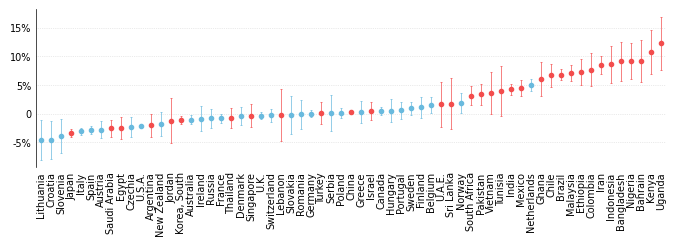

In [29]:
fig = plt.figure()
ax = plt.gca()

toPlotDelayAll = publisherDelay(delay, 'all')

acptDelayMean(toPlotDelayAll, ax)
set_size(16*cm, 4*cm, ax)

plt.savefig('../figures/figure_3a.pdf',bbox_inches = 'tight', pad_inches = 0)

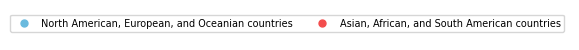

In [31]:
from matplotlib.lines import Line2D

cm = 1/2.54
legend_elements = [
    Line2D([0], [0], color='#69bade', lw=0, marker='o', markersize=5,
           label='North American, European, and Oceanian countries'),
    Line2D([0], [0], color='#f34d4d', lw=0, marker='o', markersize=5,
           label='Asian, African, and South American countries')
]

fig = plt.figure(figsize=(5*cm, 1*cm))
ax = plt.gca()
ax.legend(handles=legend_elements, loc='upper right', ncol=2)
ax.set_xticks([])
ax.set_yticks([])

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('../figures/figure_3a_legend.pdf',bbox_inches = 'tight', pad_inches = 0)

In [61]:
toPlotDelayAll.head()

,index,country,iso,region,JRelative,CI,pValue,Count,Color
0,0,Lithuania,LT,Europe,-0.045999,0.034217,8.491601e-03,689,#69bade
1,1,Croatia,HR,Europe,-0.045247,0.032914,7.115635e-03,765,#69bade
2,2,Slovenia,SI,Europe,-0.038639,0.029103,9.309806e-03,1097,#69bade
3,3,Japan,JP,Asia,-0.033732,0.006381,4.140186e-25,26687,#f34d4d
4,4,Italy,IT,Europe,-0.030226,0.006074,1.923069e-22,27314,#69bade


In [64]:
toPlotDelayAll.to_csv(DATADIR + 'acpt_delay/Countries.tsv', sep='\t', columns=['country','iso'], index=False)

# Figure 3b

In [37]:
from scipy.stats import pearsonr

In [33]:
toPlot = (
    delay.groupby(['iso','region','Year']).JRelative.mean().reset_index()
    .merge(
        delay.groupby(['iso','region','Year']).JRelative
        .apply(lambda x: ttest_1samp(x, 0).pvalue if len(x) >=2 else np.nan)
        .reset_index().rename(columns={'JRelative':'p'}), on=['iso','region','Year']
    )
    .merge(colorsDf, on='region')
    
    .query('Year >= 2000')
    .query('Year <= 2020')
    .assign(Year = lambda df: df.Year - 2000)
)
assert(toPlot.Year.min()==0)
toPlot.shape, toPlot.Year.min(), toPlot.Year.max()

((1908, 6), 0, 20)

In [38]:
%%time
redPearson = pearsonr(toPlot.query('Color == "#f34d4d"').Year,
         toPlot.query('Color == "#f34d4d"').JRelative)

bluePearson = pearsonr(toPlot.query('Color == "#69bade"').Year,
         toPlot.query('Color == "#69bade"').JRelative)

CPU times: user 7.21 ms, sys: 1.01 ms, total: 8.23 ms
Wall time: 8.03 ms


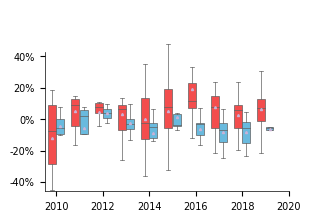

In [42]:
plt.figure(figsize=(8*cm, 6*cm))
ax = plt.gca()

g = sns.boxplot(data=toPlot.query('p < 0.05'), x="Year", y="JRelative", hue="Color", showfliers=False,
            palette={"#f34d4d":"#f34d4d", "#69bade":"#69bade"}, linewidth=0.5, width=0.7,saturation=1,
            showmeans=True,meanprops={"markeredgecolor": "#cab2d6", "markersize": "1.5", 'markerfacecolor': '#cab2d6'},
            )
g.legend_.remove()

ax.set_ylim(-0.46, 0.7)
ax.set_xlim(9.5, 19.5)

ax.set_xticks([10, 12, 14, 16, 18, 20])
ax.set_xticklabels([2010, 2012, 2014, 2016, 2018, 2020])

ax.set_yticks([-0.4, -0.2, 0, 0.2, 0.4])
ax.set_yticklabels(['-40%', '-20%', '0%', '20%', '40%'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds((-0.46, 0.43))

ax.set_ylabel('') # Relative acceptance delay
ax.set_xlabel('')

plt.savefig('../figures/figure_3b.pdf',bbox_inches = 'tight', pad_inches = 0)

# SI Figure 3

In [82]:
import geopandas
import math

In [93]:
iso2to3 = (
    pd.read_csv(DATADIR + 'worldcities.csv',usecols=['iso2','iso3'])
    .drop_duplicates()
    .rename(columns={'iso2':'iso'})
)
assert(iso2to3.iso3.duplicated().any() == False)
assert(iso2to3.iso.duplicated().any() == False)

In [83]:
path_to_data = geopandas.datasets.get_path("naturalearth_lowres")
world = (
    geopandas.read_file(path_to_data)
    .rename(columns={'iso_a3':'iso3'})
    .drop(['pop_est', 'gdp_md_est'], axis=1)
)
print(world.shape)

world.loc[world.name == 'Taiwan', 'iso3'] = 'CHN'
world.loc[world.name == 'Norway', 'iso3'] = 'NOR'
world.loc[world.name == 'France', 'iso3'] = 'FRA'
world = world[world.continent != 'Antarctica']
world = world.drop(['continent','name'], axis=1)
print('Remove Antarctica', world.shape)

world = world.query('iso3 != "-99"')
print('Remove unrecognized countries', world.shape)

world = world.dissolve(by='iso3').reset_index()
print('One China', world.shape)

(177, 4)
Remove Antarctica (176, 2)
Remove unrecognized countries (173, 2)
One China (172, 2)


In [97]:
def assignColor(row, col, baseline):
    try:
        diff = baseline-int(row[col]) # difference between the current bin and the baseline bin
        assert(4-diff >=0 and 4-diff < 10) # 10 being the total number of colors
        
        return colorSeq[4 - diff] # 4 is the index of the last green color
    except Exception as e:
        
        print('ERROR', e)
        return np.nan

In [98]:
def getPercentile(df, col, N, cutoff=None):
    
    # N: number of percentile bins
    # cutoff: below and above cutoff should be two different colors
    
    df = (
        df
        .assign(percentile = lambda df: 
                  df[col].rank(pct=True, method='max')
                  .apply(lambda x: math.ceil((x*N))) # round up percentile score
                 )
        .rename(columns={'percentile': f'{col}_Q'})
    )
    binsDf = None
    
    if cutoff is not None:
        
        # split the bin that contains cutoff into 2
        
        bins = df.groupby(f'{col}_Q')[col].max().reset_index().set_index(f'{col}_Q').to_dict()[col]
        
        ### add 1 as a bin cutoff, and shift all following bin index by 1 ###
        prev = None
        midInd = None # index of the last bin below cutoff
        
        for i in range(min(bins.keys()), N+1):
            if bins[i] > cutoff:
                if prev is None:
                    midInd = i
                    prev=bins[i]
                    bins[i] = cutoff
                else:
                    bins[i], prev = prev, bins[i]
        bins[N+1] = prev
        
        binsDf = (
            pd.DataFrame.from_dict(bins, orient='index', columns=[f'{col}_max'])
            .reset_index().rename(columns={'index': f'{col}_Q'})
            .assign(Color = lambda df: df.apply(lambda row: assignColor(row, f'{col}_Q', baseline=midInd), axis=1))
        )
        ######
        
        df = df.drop([f'{col}_Q'], axis=1)
        cols = df.columns.to_list()
        
        df = (
            df
            .assign(key=1).merge(binsDf.assign(key=1), on='key')
            .query(f'{col} <= {col}_max')
            .groupby(cols)[f'{col}_Q'].min().reset_index()
            
            .merge(binsDf[[f'{col}_Q', 'Color']], on=f'{col}_Q')
        )
    
    return df, binsDf

In [90]:
def plotMap(df, pub, world, ax=None, figsize=(24*cm, 6*cm)):
    
    if pub == 'all': pass
    else:
        df = df.query(f'Publisher == "{pub}"')
    
    paperByCountry = (
        pd.read_csv(DATADIR + 'acpt_delay/CountryPaperCount.tsv',sep='\t')
        .query('Count >= 10')
    )
    print('paper count by country (>=10)', paperByCountry.shape) # 167 # 170
        
    timeByCountry = (
        df

        .groupby(['country','iso','region']).JRelative.mean().reset_index()
        .merge(
            delay.groupby(['country','iso','region']).JRelative.apply(CI)
            .reset_index().rename(columns={'JRelative':'CI'}), on=['country','iso','region']
        )
        .assign(pValue = lambda df: df.iso.apply(calcPbyISO))
        .merge(paperByCountry, on=['country', 'iso'])
    )
    print('Average acceptance delay of each country', timeByCountry.shape) # 138
    
    world = (
        world.merge(iso2to3, on='iso3')
        .merge(timeByCountry, on='iso')#, how='left'
    )
    print('acceptance delay of country', world.shape)

    numBins=5

    relativeBins, bins = getPercentile(
        world.query('pValue < 0.01')[['iso3','JRelative']],
        'JRelative', numBins, 0
    )

    assert(relativeBins.shape[0] ==  world.query('pValue < 0.01').shape[0])
    if numBins + 1 != bins.shape[0]:
        print('warning! number of bins', bins.shape[0])

    world = (
        pd.concat([
            world.query('pValue < 0.01').merge(relativeBins.drop(['JRelative'], axis=1), on='iso3'),
            world.query('pValue >= 0.01').assign(Color='lightgrey')
        ], ignore_index=True, sort=False)
    )

    print(world.shape, 'should be the same as before')
    
    if ax is None: ax = plt.gca()

    set_size(figsize[0], figsize[1], ax)

    world.plot(ax = ax, color=world.Color)

    ax.set_xticks([])
    ax.set_yticks([])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    return bins, world

In [91]:
def plotPallete(cSeq, labels, world, ax=None, vertical=False, scale=1):
    
    n = len(cSeq)
    labels = [world.query('pValue < 0.01').JRelative.min()] + labels
    
    labels = [f'{round(x*100, 0):g}%' for x in labels]
    
    if vertical:
        if ax is None:
            
            ax = plt.gca()
            set_size(1*cm*scale, n*cm*scale)
    
        ax.set_ylim(0, n)
        ax.set_xlim(0, 1)
        ax.set_xticks([])
        
        ax.set_yticks([x for x in range(n+1)])
        ax.set_yticklabels(labels)#[f"{round(x, 2):g}" for x in labels])
        
        for i in range(n):
            ax.fill_between([0, 1], i, i+1, facecolor=cSeq[i])
    else:
        
        if ax is None:
            
            ax = plt.gca()
            set_size(1*cm*scale, n*cm*scale)
            
        set_size(n*cm*scale, 1*cm*scale)
    
        ax.set_xlim(0, n)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        
        ax.set_xticks([x for x in range(n+1)])
        ax.set_xticklabels(labels)
    
        for i in range(n):
            ax.fill_between([i, i+1], 0, 1, facecolor=cSeq[i])

In [100]:
colorSeq = [
    'black',
    '#543005', 
    '#8c510a', 
    '#bf812d', 
    '#dfc27d', 
    '#80cdc1', 
    '#35978f', 
    '#01665e', 
    '#003c30',
    'black',
]

colorSeq = colorSeq[-1::-1]
len(colorSeq)

10

paper count by country (>=10) (138, 3)
Average acceptance delay of each country (138, 7)
acceptance delay of country (128, 9)
(128, 11) should be the same as before


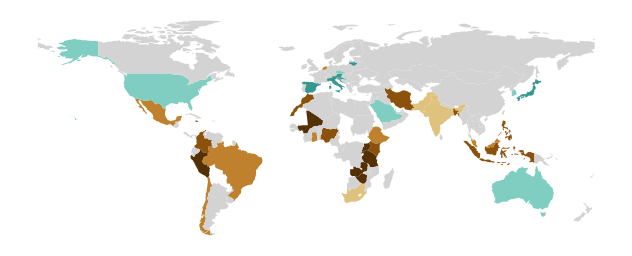

In [101]:
bins, mapWorld = plotMap(delay, 'all', world)

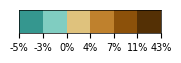

In [102]:
plotPallete(bins.Color, list(bins.JRelative_max), mapWorld, vertical=False, scale=0.6)

In [106]:
# supplementary table 3
print(
    mapWorld[['country','JRelative','Count']].sort_values(by='Count',ascending=False)
    .assign(JRelative=lambda df: df.JRelative.apply(lambda x: f'{round(x*100, 2)}%'))
    
    .head(10) # remove this to see all countries
    .rename(columns={'country':'Country','JRelative':'Average RAD','Count':'No. papers'})
    .style.to_latex()
)

\begin{tabular}{lllr}
 & Country & Average RAD & No. papers \\
34 & U.S.A. & -2.12% & 170104 \\
53 & China & 0.3% & 168039 \\
61 & Germany & 0.02% & 38358 \\
70 & U.K. & -0.32% & 34582 \\
14 & Italy & -3.02% & 27314 \\
16 & Japan & -3.37% & 26687 \\
51 & Canada & 0.49% & 21950 \\
7 & Spain & -2.89% & 21518 \\
69 & France & -0.78% & 20077 \\
18 & Korea, South & -1.15% & 19623 \\
\end{tabular}



# SI Figure 6

In [49]:
from tqdm.notebook import tqdm

In [54]:
def discipTstat():
    
    res = []
    for field in tqdm(fieldDelay.FieldName.unique()):
        
        subset = fieldDelay.query(f'FieldName == "{field}"')
        red = subset.query('Color == "#f34d4d"')
        blue = subset.query('Color == "#69bade"')
    
        test = ttest_ind(red.JRelative, blue.JRelative, equal_var=False, permutations=5000, random_state=42)
    
        res.append((field, test[0], test[1]))
    
    
    return res

In [55]:
fieldDelay = pd.read_csv(DATADIR + 'acpt_delay/PaperFieldDelay.tsv',sep='\t')

In [56]:
fieldDelay.shape

(1676400, 4)

In [59]:
%%time
fieldMean = discipTstat()

  0%|          | 0/19 [00:00<?, ?it/s]

CPU times: user 3min 55s, sys: 1min 32s, total: 5min 28s
Wall time: 5min 29s


In [68]:
def plotDiscpline(sortedField, df=fieldDelay):
    
    row=4
    col=5
    
    axes = [plt.subplot(row, col, x+1) for x in range(19)]
    ymin, ymax = 0, 0
    
    for ind, field in tqdm(enumerate(sortedField)):
        
        sns.pointplot(
            data=fieldDelay.query(f'FieldName == "{field}"'), x='Color', y='JRelative', ax=axes[ind],
            join=False, order=['#f34d4d','#69bade'], palette={'#f34d4d':'#f34d4d','#69bade':'#69bade'},
            errwidth=0.5, capsize=0.2, scale=0.2
        )
        
        ylo, yhi = axes[ind].get_ylim()
        ymax = max(ymax, yhi)
        ymin = min(ymin, ylo)
        
        axes[ind].set_title(field.replace(' ','\n'), fontsize=6)
        axes[ind].set_ylabel('Relative acceptance delay')
        
        testAndPlot(field, ax=axes[ind], height=yhi)
        
    for ind, ax in enumerate(axes):
        ax.set_ylim(ymin*1.2, ymax*1.2)
        ax.set_xticklabels([])
        ax.set_xticks([])
        
        if ind % col != 0:
            ax.set_ylabel('')
            ax.set_yticklabels([])
            
        ax.set_xlabel('')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    plt.tight_layout()

In [69]:
def plotPvalue(ax, x, height, pVal, gap, vlength, lw=0.2, c='black'):
    # x: [x0, x1]
    # y: [y0, y1]
    
    yPos = height + gap + vlength
    ax.hlines(yPos, x[0], x[1], color=c, lw=lw)
    ax.vlines(x[0], height + gap, yPos, color=c, lw=lw)
    ax.vlines(x[1], height + gap, yPos, color=c, lw=lw)
    
    stars = '$p$ < 0.001' if pVal < 0.001 else f'$p$ = {round(pVal, 3)}'
    offset = 0.01 if pVal < 0.05 else 0.04
    
    ax.text((x[0] + x[1])/2, yPos , stars, ha='center', va='bottom', color=c)
    
    return yPos

In [70]:
def testAndPlot(field, ax, height):
    
    test = ttest_ind(
        fieldDelay.query(f'FieldName == "{field}"').query('Color == "#f34d4d"').JRelative,
        fieldDelay.query(f'FieldName == "{field}"').query('Color == "#69bade"').JRelative,
        equal_var=False
    )
    
    height = plotPvalue(ax, [0, 1], height, test[1], 0.002, 0.008, lw=0.2, c='black')

0it [00:00, ?it/s]

CPU times: user 19 s, sys: 212 ms, total: 19.2 s
Wall time: 19.1 s


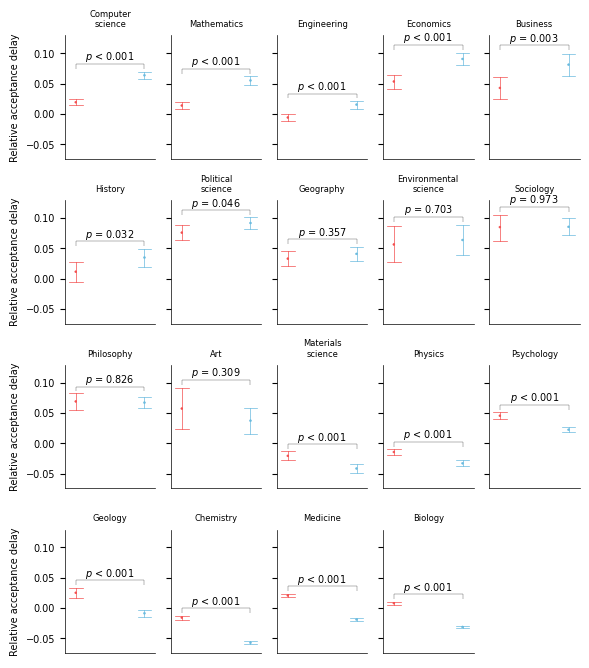

In [71]:
%%time
plt.figure(figsize=(15*cm, 17*cm))
plotDiscpline([x for x, _, _ in sorted(fieldMean, key=lambda x: x[1])])

# Figure 2e

In [76]:
interaction = pd.read_csv(DATADIR + 'acpt_delay/CountryInteraction.tsv',sep='\t')

In [77]:
def countryttest(country):
    
    sub = interaction.query(f'country == "{country}"')
    ttest = ttest_ind(sub.query('SameCountry == True').JRelative,
                      sub.query('SameCountry == False').JRelative, equal_var=False)
    
    return ttest[0], ttest[1]

countryOrder = sorted(
    [(country, countryttest(country)[0], countryttest(country)[1])
     for country in interaction.country.unique()], key=lambda x: x[1]
)
countryOrderSig = [x for x, _, p in countryOrder if p < 0.05]
countryOrderInSig = [x for x, _, p in countryOrder if p >= 0.05]

In [78]:
len(countryOrderSig), len(countryOrderInSig)

(13, 50)

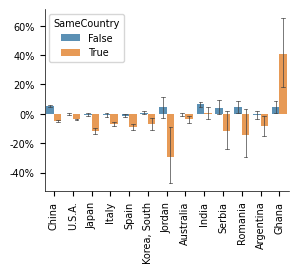

In [80]:
plt.figure(figsize=(8*cm, 6*cm))
ax = plt.gca()


sns.barplot(data=interaction, y='JRelative', x='country', hue='SameCountry', ax=ax,
            errwidth=0.5, alpha=0.8, capsize=0.2, 
            order=countryOrderSig)

ax.tick_params(rotation=90, axis='x')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')

ax.set_yticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6])
ax.set_yticklabels(['-40%', '-20%', '0%', '20%', '40%', '60%'])
plt.savefig('../figures/figure_3e.pdf',bbox_inches = 'tight', pad_inches = 0)

## SI Figure 7

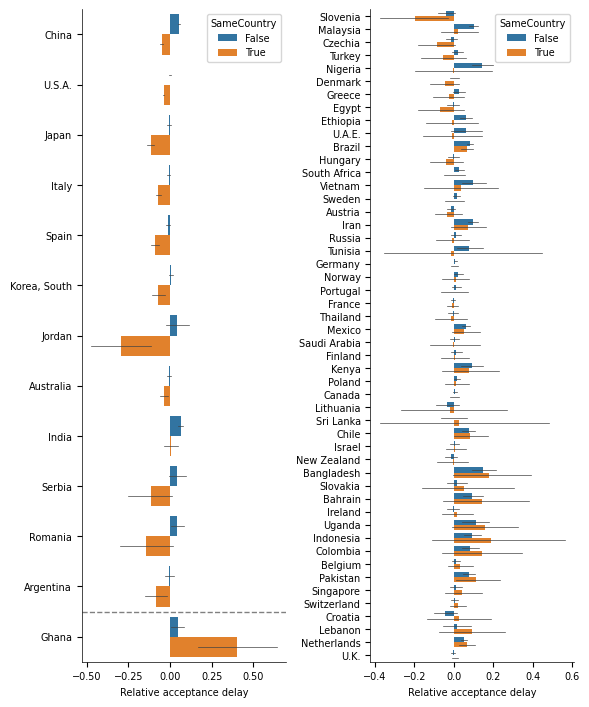

In [81]:
plt.figure(figsize=(15*cm, 18*cm))

ax = plt.subplot(1, 2, 1)
sns.barplot(data=interaction, x='JRelative', y='country', hue='SameCountry', errwidth=0.5, ax=ax, 
            order=countryOrderSig)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Relative acceptance delay')
ax.set_ylabel('')

## plot a line seperating positive t's from negative t's ##
xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.plot(xlim, [11.5, 11.5], ls='--', lw=1, color='gray')

ax.set_ylim(ylim)
ax.set_xlim(xlim)
####

ax = plt.subplot(1, 2, 2)
sns.barplot(data=interaction, x='JRelative', y='country', hue='SameCountry', errwidth=0.5, ax=ax,
            order=countryOrderInSig)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Relative acceptance delay')
ax.set_ylabel('')

plt.tight_layout()

# Figure 3c

In [118]:
raceDelay = pd.read_csv(DATADIR + 'acpt_delay/PaperRaceDelay.tsv',sep='\t')

In [119]:
COLOR = {
    'White': '#377eb8',
    'API': '#4daf4a',
    'Hispanic': '#ff7f00',
    'Black': '#e41a1c'
}

In [120]:
def testAndPlot(a, b, ax, height):
    
    xpos={'White': 0, 'API': 1, "Hispanic":2, 'Black': 3}
    
    test = ttest_ind(raceDelay.query(f'Race == "{a}"').JRelative,
              raceDelay.query(f'Race == "{b}"').JRelative, equal_var=False)
    
    height = plotPvalue(ax, [xpos[a]+0.01, xpos[b]-0.01], height, test[1], 0.05, 0.1, lw=0.2, c='black')

In [121]:
def plotPvalue(ax, x, height, pVal, gap, vlength, lw=0.2, c='black'):
    # x: [x0, x1]
    # y: [y0, y1]
    
    yPos = height + gap + vlength
    ax.hlines(yPos, x[0], x[1], color=c, lw=lw)
    ax.vlines(x[0], height + gap, yPos, color=c, lw=lw)
    ax.vlines(x[1], height + gap, yPos, color=c, lw=lw)
    
    stars = '$p$ < 0.001' if pVal < 0.001 else f'$p$ = {round(pVal, 3)}'
    offset = 0.01 if pVal < 0.05 else 0.04
    
    ax.text((x[0] + x[1])/2, yPos , stars, ha='center', va='bottom', color=c)
    
    return yPos

CPU times: user 334 ms, sys: 89.6 ms, total: 424 ms
Wall time: 334 ms


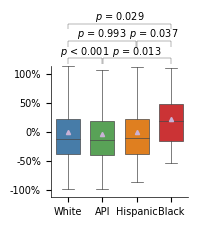

In [122]:
%%time
plt.figure(figsize=(4.5*cm, 6*cm))

ax = plt.gca()

sns.boxplot(data=raceDelay, x='Race', y='JRelative', order=['White','API','Hispanic','Black'],
            palette=COLOR, showfliers=False, showmeans=True, linewidth=0.5, width=0.7,
            meanprops={"markeredgecolor": "#cab2d6", "markersize": "3", 'markerfacecolor': '#cab2d6'})

ax.set_yticks([-1, -0.5, 0, 0.5, 1])  
ax.set_yticklabels(['-100%', '-50%', '0%', '50%', '100%'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


testAndPlot('White', 'API', ax, 1.12)
testAndPlot('API', 'Black', ax, 1.12)


testAndPlot('White', 'Hispanic', ax, 1.42)
testAndPlot('Hispanic', 'Black', ax, 1.42)

testAndPlot('White', 'Black', ax, 1.72)

ylim = ax.get_ylim()
ax.spines['left'].set_bounds((ylim[0], -ylim[0]))

ax.set_xlabel('')
ax.set_ylabel('')

plt.savefig('../figures/figure_3c.pdf',bbox_inches = 'tight', pad_inches = 0)

# Figure 3d

In [131]:
def plotRace(race, ax):
    
    sub = toPlot.query(f'Race == "{race}"')
    minYear, maxYear = sub.Year.min(), sub.Year.max()
    
    sub = sub.assign(Year = lambda df: df.Year - df.Year.min())
    
    sns.regplot(data=sub,
            x='Year', y='JRelative', ax=ax, color=COLOR[race], scatter=False, line_kws={"lw": 1}
           )
    
    sns.pointplot(data=sub,
              x='Year', y='JRelative', color=COLOR[race], ax=ax, join=False,
             errwidth=0.5, capsize=0.2, scale=0.3)
    
    corr = pearsonr(
        toPlot.query(f'Race == "{race}"').Year, toPlot.query(f'Race == "{race}"').JRelative
    )
    
#     ax.text(0.5, 1, '$r$ = {:.3f}, $p$ = {:.3f}'.format(corr[0], corr[1]), color=COLOR[race])
#     print(ax.get_ylim())
    
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_ylim(-0.6, 1.68)
    
    ax.set_xticks([x for x in range(0, maxYear-minYear+1, 5)])
    ax.set_xticklabels([f'{x+minYear}' for x in range(0, maxYear-minYear+1, 5)])
    
    ax.set_yticks([-0.5, 0, 0.5, 1])  
    ax.set_yticklabels(['-50%', '0%', '50%', '100%'])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)  
    ax.spines['left'].set_bounds((-0.6, 1.1))

In [132]:
toPlot = (
    raceDelay
    .query('Year >= 2000')
    .query('Year <= 2020')
)

In [133]:
toPlot.shape # 40672 # 22548 if all US

(22548, 3)

CPU times: user 3.64 s, sys: 367 ms, total: 4 s
Wall time: 3.65 s


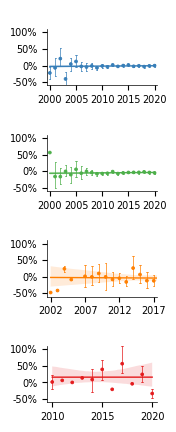

In [134]:
%%time
plt.figure(figsize=(4.5*cm, 11*cm))

ax = plt.subplot(4,1,1)
plotRace('White', ax)

ax = plt.subplot(4,1,2)
plotRace('API', ax)

ax = plt.subplot(4,1,3)
plotRace('Hispanic', ax)

ax = plt.subplot(4,1,4)
plotRace('Black', ax)

plt.tight_layout()
plt.savefig('../figures/figure_3d.pdf',bbox_inches = 'tight', pad_inches = 0)

# Figure 3f

In [138]:
palette ={True: "#377eb8", False: '#a65628'}

In [139]:
interaction = pd.read_csv(DATADIR + 'acpt_delay/RaceInteraction.tsv',sep='\t')

In [143]:
def testAndPlot(q0, q1, q2, q3, ax, height):
    
    xpos={True: {True: -0.2, False: 0.2}, False: {True: 0.8, False: 1.2}}
    
    test = ttest_ind(
        interaction.query(f'PaperIsWhite == {q0}').query(f'EditorIsWhite == {q2}').JRelative,
        interaction.query(f'PaperIsWhite == {q1}').query(f'EditorIsWhite == {q3}').JRelative,
        equal_var=False
    )
    
    height = plotPvalue(ax, [xpos[q0][q2], xpos[q1][q3]], height, test[1], 0.002, 0.005, lw=0.2, c='black')

CPU times: user 465 ms, sys: 86.4 ms, total: 552 ms
Wall time: 460 ms


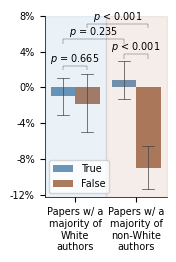

In [144]:
%%time
plt.figure(figsize=(4*cm, 6*cm))
matplotlib.rc('font', **{'size': 7})

ax = plt.gca()
g = sns.barplot(data=interaction, order=[True, False], hue_order=[True, False],
            x='PaperIsWhite', hue='EditorIsWhite', y='JRelative', ax=ax,
            palette=palette, alpha=0.8, capsize=.2, errwidth=0.5
           )

ax.set_xticks([0, 1])
ax.set_xticklabels(['Papers w/ a\nmajority of\nWhite\nauthors', 'Papers w/ a\nmajority of\nnon-White\nauthors'])
ax.set_xlabel('')
ax.set_ylabel('Relative acceptance delay')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('')

ax.set_yticks([-0.12, -0.08, -0.04, 0, 0.04, 0.08])
ax.set_yticklabels(['-12%','-8%', '-4%', '0%', '4%', '8%'])

g.legend_.set_title('Race of editor') # remember to change legend label
plt.legend(loc='lower left')



testAndPlot(True, True, True, False, ax, height=0.017)
testAndPlot(False, False, True, False, ax, height=0.03)

testAndPlot(True, False, True, True, ax, height=0.047)
testAndPlot(True, False, False, False, ax, height=0.064)

lo, hi = ax.get_ylim()

ax.fill_between([-0.5, 0.5], [lo, lo], [hi, hi], alpha=0.1, color=palette[True])
ax.fill_between([0.5, 1.5], [lo, lo], [hi, hi], alpha=0.1, color=palette[False])

ax.set_xlim(-0.5, 1.5)
ax.set_ylim(lo, hi)

plt.savefig('../figures/figure_3f.pdf',bbox_inches = 'tight', pad_inches = 0)

# SI Figure 9

In [162]:
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from statsmodels.iolib.summary2 import summary_col

In [172]:
nineteenFields = pd.read_csv(DATADIR + 'Fields.tsv', sep='\t')
field_control = ' + '.join(nineteenFields.FieldName.apply(lambda x: '_'.join(x.split())).unique())

with open(DATADIR + 'CountryControl.txt', 'r') as f:
    country_control = f.read()

In [173]:
def getRegressionResult(toRegress, US=False):
    
    model = "JRelative ~ Total + Year + Age + API+Black+Hispanic + SameRace+SameCountry + C(Rank) +" + field_control
    
    if not US:
        model = model + ' + ' + country_control
        
    if US:
        toRegress = toRegress.merge(USpapers, on='PaperId')
        print('US papers only', toRegress.shape, toRegress.PaperId.nunique())
    
    model = ols(model, data=toRegress)
    results = model.fit(cov_type = 'HAC', cov_kwds={'maxlags':10})
    
    meanConfInt = (
        results.conf_int().assign(Mean = lambda df: (df[0] + df[1])/2)
        .rename(columns={0:'lo', 1:'hi'})
        .assign(err = lambda df: (df.hi-df.lo)/2)
        .reset_index()
        .rename(columns={'index':'Race'})
        .merge(results.pvalues.reset_index(name='pvalue').rename(columns={'index':'Race'}), on='Race')
    )
    
    return meanConfInt, results

In [176]:
%%time
paperDf = pd.concat([
    pd.read_csv(DATADIR + f'acpt_delay/regression_data/{ind}.tsv',sep='\t') for ind in tqdm(range(10))
], ignore_index=True, sort=False)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 9.77 s, sys: 1.88 s, total: 11.7 s
Wall time: 12.7 s


In [177]:
paperDf.shape

(783790, 216)

In [178]:
paperDf.columns.values

array(['JRelative', 'Year', 'Total', 'API', 'Black', 'Hispanic', 'White',
       'AE', 'AF', 'AG', 'AL', 'AM', 'AO', 'AR', 'AS', 'AT', 'AU', 'AZ',
       'BA', 'BD', 'BE', 'BF', 'BG', 'BH', 'BI', 'BJ', 'BM', 'BN', 'BO',
       'BR', 'BS', 'BT', 'BW', 'BY', 'BZ', 'CA', 'CD', 'CG', 'CH', 'CI',
       'CL', 'CM', 'CN', 'CO', 'CR', 'CU', 'CV', 'CY', 'CZ', 'DE', 'DK',
       'DO', 'DZ', 'EC', 'EE', 'EG', 'ER', 'ES', 'ET', 'FI', 'FJ', 'FO',
       'FR', 'GA', 'GB', 'GD', 'GE', 'GF', 'GH', 'GI', 'GL', 'GM', 'GN',
       'GR', 'GT', 'GU', 'GW', 'GY', 'HN', 'HR', 'HU', 'ID', 'IE', 'IL',
       'IN', 'IQ', 'IR', 'IS', 'IT', 'JE', 'JM', 'JO', 'JP', 'KE', 'KG',
       'KH', 'KN', 'KP', 'KR', 'KW', 'KY', 'KZ', 'LA', 'LB', 'LI', 'LK',
       'LR', 'LS', 'LT', 'LU', 'LV', 'LY', 'MA', 'MD', 'ME', 'MG', 'MH',
       'MK', 'ML', 'MM', 'MN', 'MR', 'MT', 'MU', 'MW', 'MX', 'MY', 'MZ',
       'NC', 'NE', 'NG', 'NI', 'NL', 'NO', 'NP', 'NZ', 'OM', 'PA', 'PE',
       'PF', 'PG', 'PH', 'PK', 'PL', 'PR', 'PT', '

In [179]:
%%time
resSimp, res = getRegressionResult(paperDf, US=False)

CPU times: user 1min 46s, sys: 8.42 s, total: 1min 55s
Wall time: 1min 9s


In [180]:
raceToPlot = resSimp[resSimp.Race.isin(['White', 'API', 'Hispanic', 'Black'])].sort_values(by='err')
# percentage of race, without Total, with discpline

In [182]:
raceToPlot

,Race,lo,hi,Mean,err,pvalue
93,API,-0.002441,-0.000554,-0.001497,0.000943,1.860406e-03
95,Hispanic,-0.001433,0.003278,0.000922,0.002355,4.427190e-01
94,Black,0.017118,0.028034,0.022576,0.005458,5.182735e-16


In [188]:
countryToPlot = (
    resSimp[resSimp.Race.isin([x.strip() for x in country_control.split('+')])]
    .rename(columns={'Race':'iso'})
    .merge(continents, on='iso')
    .merge(colorsDf, on='region')
)
countryToPlot.shape

(184, 8)

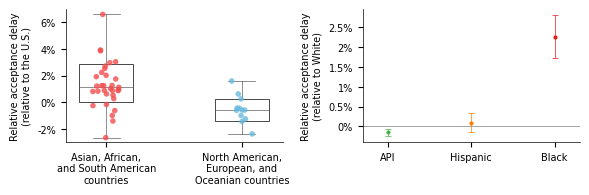

In [189]:
plt.figure(figsize=(15*cm, 5*cm))

ax = plt.subplot(1, 2, 1)
sns.stripplot(data=countryToPlot.query('pvalue < 0.05'), x='Color', y='Mean', ax=ax,
           palette={'#f34d4d':'#f34d4d','#69bade':'#69bade'}, alpha=0.8, size=4, 
           )

sns.boxplot(data=countryToPlot.query('pvalue < 0.05'), x='Color', y='Mean', ax=ax, showfliers=False,
           palette={'#f34d4d':'#f34d4d','#69bade':'#69bade'}, linewidth=0.5, width=0.4,
            showmeans=False, **{'boxprops':{'facecolor':'none', 'edgecolor':'black'}}
           )
            
ax.set_ylim(-0.03, 0.07)

ax.set_ylabel('Relative acceptance delay\n(relative to the U.S.)')
ax.set_xlabel('')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Asian, African,\nand South American\ncountries',
                    'North American,\nEuropean, and\nOceanian countries'
                    ])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(-0.3, 1.3)

ax.set_yticks([-0.02, 0, 0.02, 0.04, 0.06])
ax.set_yticklabels(['-2%', '0%', '2%', '4%', '6%'])


ax = plt.subplot(1, 2, 2)

ax.errorbar(x=[0], y=raceToPlot.Mean.values[0],
            yerr=raceToPlot.apply(lambda row: row.Mean-row.lo, axis=1).values[0],
            fmt = ' ', marker='o', ms=2, elinewidth=0.5, capsize=2, capthick=0.5,
            color=COLOR['API'])

ax.errorbar(x=[1], y=raceToPlot.Mean.values[1],
            yerr=raceToPlot.apply(lambda row: row.Mean-row.lo, axis=1).values[1],
            fmt = ' ', marker='o', ms=2, elinewidth=0.5, capsize=2, capthick=0.5,
            color=COLOR['Hispanic'])

ax.errorbar(x=[2], y=raceToPlot.Mean.values[2],
            yerr=raceToPlot.apply(lambda row: row.Mean-row.lo, axis=1).values[2],
            fmt = ' ', marker='o', ms=2, elinewidth=0.5, capsize=2, capthick=0.5,
            color=COLOR['Black'])

ax.plot([-1, 5], [0, 0], color='gray', lw=0.5)
ax.set_ylabel('Relative acceptance delay\n(relative to White)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['API','Hispanic','Black'])
ax.set_xlim(-0.3, 2.3)

ax.set_yticks([0, 0.005, 0.01, 0.015, 0.02, 0.025])
ax.set_yticklabels(['0%', '0.5%', '1%', '1.5%', '2%', '2.5%'])

plt.tight_layout()